# Loading required libraries

In [ ]:
import os
import shutil
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.io as pio
import tensorflow as tf
import optuna
import shap

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import shapiro, f_oneway, kruskal, mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.callbacks import EarlyStopping

from matplotlib.backends.backend_pdf import PdfPages

from multiprocessing import cpu_count, Pool

os.getcwd()

# def delete_subfolders(directory):
#     # List all items in the specified directory
#     for item in os.listdir(directory):
#         item_path = os.path.join(directory, item)
#         # Check if the item is a directory
#         if os.path.isdir(item_path):
#             # Remove the directory and its contents
#             shutil.rmtree(item_path)
#             print(f"Deleted folder: {item_path}")

# # Specify the directory
# directory = './data/'

# # Call the function
# delete_subfolders(directory)

os.getcwd()


# Pre-processing data

In [5]:
# # Load the preprocessed dataset
# df = pd.read_csv('./data/df_preprocessed.csv')
# df.set_index(df.columns[0], inplace=True)

# # Columns to consider for inclusion/exclusion
# target = 'actual_casetime_minutes'
# numerical_columns = ['scheduled_duration', 'avg_bmi', 'age_at_discharge', 'day_of_year', 'day_of_week', 'asa_score']

# # Split features and target
# features = df.drop(columns=[target])
# X_train, X_test, y_train, y_test = train_test_split(features, df[target], test_size=0.2, random_state=42)

# # Normalize numerical features using Min-Max Scaler
# scaler = MinMaxScaler(feature_range=(0, 1))
# X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
# X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# # Convert normalized data back to DataFrame to preserve indices
# X_train = pd.DataFrame(X_train, columns=features.columns, index=X_train.index)
# X_test = pd.DataFrame(X_test, columns=features.columns, index=X_test.index)

# print(f"Dimensions of final preprocessed X_train: {X_train.shape}")
# print(f"Dimensions of final preprocessed X_test: {X_test.shape}")

# # Base directory for saving data
# base_dir = './data/'

# # Function to save dataframes to specified folder
# def save_dataframes(X_train, X_test, Y_train, Y_test, folder_name):
#     # Create base directory if it doesn't exist
#     if not os.path.exists(base_dir):
#         os.makedirs(base_dir)
    
#     # Full path for the specific folder
#     full_path = os.path.join(base_dir, folder_name)
    
#     # Create directory if it doesn't exist
#     if not os.path.exists(full_path):
#         os.makedirs(full_path)
       
#     # Drop missing values
#     X_train_clean = X_train.dropna()
#     X_test_clean = X_test.dropna()
    
#     # Align Y_train and Y_test with cleaned X_train and X_test
#     Y_train_clean = Y_train.loc[X_train_clean.index]
#     Y_test_clean = Y_test.loc[X_test_clean.index]
    
#     # Save to CSV files
#     X_train_clean.to_csv(os.path.join(full_path, 'X_train.csv'))
#     X_test_clean.to_csv(os.path.join(full_path, 'X_test.csv'))
#     Y_train_clean.to_csv(os.path.join(full_path, 'Y_train.csv'))
#     Y_test_clean.to_csv(os.path.join(full_path, 'Y_test.csv'))
    
#     # Print dimensions of X_train and X_test
#     print(f"Dimensions of X_train in {folder_name}: {X_train_clean.shape}")
#     print(f"Dimensions of X_test in {folder_name}: {X_test_clean.shape}")

# # Scenario: with_bmi_with_scheduled_duration
# X_train_with_bmi_with_scheduled_duration = X_train.copy()
# X_test_with_bmi_with_scheduled_duration = X_test.copy()
# save_dataframes(X_train_with_bmi_with_scheduled_duration, X_test_with_bmi_with_scheduled_duration, y_train, y_test, 'with_bmi_with_scheduled_duration')

# # Scenario: with_bmi_without_scheduled_duration
# X_train_with_bmi_without_scheduled_duration = X_train.copy().drop(columns=['scheduled_duration'], errors='ignore')
# X_test_with_bmi_without_scheduled_duration = X_test.copy().drop(columns=['scheduled_duration'], errors='ignore')
# save_dataframes(X_train_with_bmi_without_scheduled_duration, X_test_with_bmi_without_scheduled_duration, y_train, y_test, 'with_bmi_without_scheduled_duration')

# # Scenario: without_bmi_with_scheduled_duration
# X_train_without_bmi_with_scheduled_duration = X_train.copy().drop(columns=['avg_bmi'], errors='ignore')
# X_test_without_bmi_with_scheduled_duration = X_test.copy().drop(columns=['avg_bmi'], errors='ignore')
# save_dataframes(X_train_without_bmi_with_scheduled_duration, X_test_without_bmi_with_scheduled_duration, y_train, y_test, 'without_bmi_with_scheduled_duration')

# # Scenario: without_bmi_without_scheduled_duration
# X_train_without_bmi_without_scheduled_duration = X_train.copy().drop(columns=['avg_bmi', 'scheduled_duration'], errors='ignore')
# X_test_without_bmi_without_scheduled_duration = X_test.copy().drop(columns=['avg_bmi', 'scheduled_duration'], errors='ignore')
# save_dataframes(X_train_without_bmi_without_scheduled_duration, X_test_without_bmi_without_scheduled_duration, y_train, y_test, 'without_bmi_without_scheduled_duration')


Dimensions of final preprocessed X_train: (13796, 65)
Dimensions of final preprocessed X_test: (3450, 65)
Dimensions of X_train in with_bmi_with_scheduled_duration: (9009, 65)
Dimensions of X_test in with_bmi_with_scheduled_duration: (2239, 65)
Dimensions of X_train in with_bmi_without_scheduled_duration: (9009, 64)
Dimensions of X_test in with_bmi_without_scheduled_duration: (2239, 64)
Dimensions of X_train in without_bmi_with_scheduled_duration: (13796, 64)
Dimensions of X_test in without_bmi_with_scheduled_duration: (3450, 64)
Dimensions of X_train in without_bmi_without_scheduled_duration: (13796, 63)
Dimensions of X_test in without_bmi_without_scheduled_duration: (3450, 63)


# Heyper-Parameter Optimization

In [ ]:
# import os
# import pandas as pd
# import json
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# import optuna

# # # Ensure TensorFlow uses the GPU if available
# # physical_devices = tf.config.experimental.list_physical_devices('GPU')
# # if len(physical_devices) > 0:
# #     tf.config.experimental.set_memory_growth(physical_devices[0], True)

# # Function to create the model
# def create_model(trial, input_shape):
#     model = Sequential()
#     model.add(Dense(trial.suggest_int('units_l1', 64, 512), activation=trial.suggest_categorical('activation_l1', ['relu', 'elu', 'selu']), input_shape=(input_shape,)))
#     model.add(BatchNormalization())
#     model.add(Dropout(trial.suggest_float('dropout_l1', 0.2, 0.5)))

#     for i in range(trial.suggest_int('n_layers', 2, 6)):
#         model.add(Dense(trial.suggest_int(f'units_l{i+2}', 64, 512), activation=trial.suggest_categorical(f'activation_l{i+2}', ['relu', 'elu', 'selu'])))
#         model.add(BatchNormalization())
#         model.add(Dropout(trial.suggest_float(f'dropout_l{i+2}', 0.2, 0.5)))

#     model.add(Dense(1, activation='linear'))

#     model.compile(optimizer=Adam(learning_rate=trial.suggest_float('lr', 1e-5, 1e-1, log=True)),
#                   loss='mean_squared_error', 
#                   metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])
    
#     return model

# # Function to load data, optimize the model and save the results
# def optimize_model_for_scenario(folder_name):
#     # Define file paths
#     base_dir = './data/'
#     folder_path = os.path.join(base_dir, folder_name)
    
#     # Load data
#     X_train = pd.read_csv(os.path.join(folder_path, 'X_train.csv'), index_col=0)
#     X_test = pd.read_csv(os.path.join(folder_path, 'X_test.csv'), index_col=0)
#     y_train = pd.read_csv(os.path.join(folder_path, 'Y_train.csv'), index_col=0)
#     y_test = pd.read_csv(os.path.join(folder_path, 'Y_test.csv'), index_col=0)
    
#     input_shape = X_train.shape[1]

#     # Define objective function for optimization
#     def objective(trial):
#         model = create_model(trial, input_shape)
#         history = model.fit(X_train, y_train, 
#                             validation_split=0.2, 
#                             epochs=200,  # Set number of epochs to 10
#                             batch_size=trial.suggest_int('batch_size', 16, 128), 
#                             callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
#                             verbose=0)
#         score = model.evaluate(X_test, y_test, verbose=0)
#         return score[0]

#     # Optimize the model using Optuna
#     study = optuna.create_study(direction='minimize')
#     study.optimize(objective, n_trials=50, timeout=1200, n_jobs=-1)  # Set number of trials to 5

#     # Save the best parameters to a file
#     with open(os.path.join(folder_path, 'bestparams.json'), 'w') as file:
#         json.dump(study.best_params, file, indent=4)

#     print(f"Best parameters for {folder_name}:")
#     print(study.best_params)

# # Define the list of scenarios
# scenarios = [
#     # 'with_bmi_with_scheduled_duration',
#     # 'with_bmi_without_scheduled_duration',
#     # 'without_bmi_with_scheduled_duration',
#     'without_bmi_without_scheduled_duration'
# ]

# # Run optimization for each scenario
# for scenario in scenarios:
#     optimize_model_for_scenario(scenario)


# Best Model

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2024-06-22 00:20:21.575607: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14784 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1d:00.0, compute capability: 7.0
I0000 00:00:1719030026.402367 2629962 service.cc:145] XLA service 0x14b38c005db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719030026.402581 2629962 service.cc:153]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-06-22 00:20:26.653875: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-22 00:20:27.386737: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:4

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1781.3461 - mean_absolute_error: 26.2516 - mean_absolute_percentage_error: 21.7354
Test MAE for with_bmi_with_scheduled_duration: 26.856996536254883
Test MAPE for with_bmi_with_scheduled_duration: 21.82424545288086


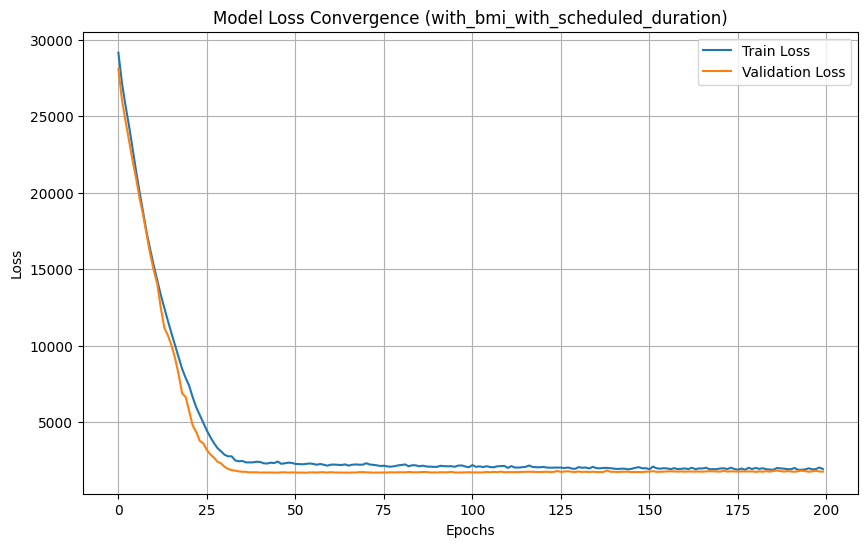

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/lustre03/project/6010096/moenoor/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2557.2039 - mean_absolute_error: 31.0458 - mean_absolute_percentage_error: 24.0624
Test MAE for with_bmi_without_scheduled_duration: 32.068233489990234
Test MAPE for with_bmi_without_scheduled_duration: 24.47049331665039


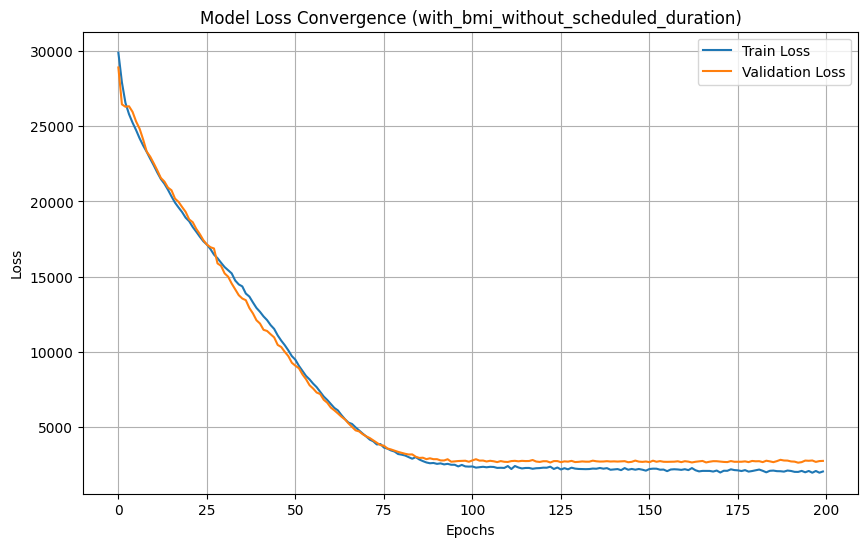

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


/lustre03/project/6010096/moenoor/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1900.0969 - mean_absolute_error: 27.1096 - mean_absolute_percentage_error: 21.4520 
Test MAE for without_bmi_with_scheduled_duration: 27.007627487182617
Test MAPE for without_bmi_with_scheduled_duration: 21.59467887878418


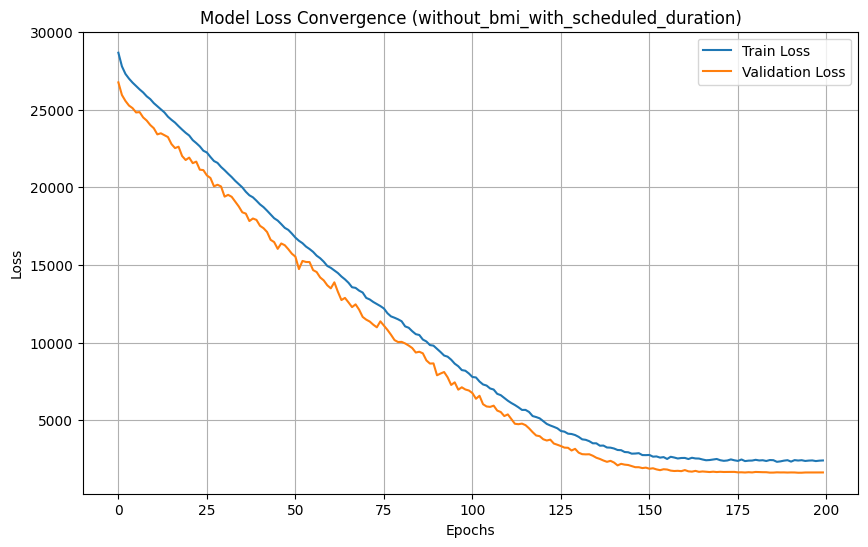

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/lustre03/project/6010096/moenoor/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2542.0356 - mean_absolute_error: 31.8942 - mean_absolute_percentage_error: 25.4719
Test MAE for without_bmi_without_scheduled_duration: 31.85641098022461
Test MAPE for without_bmi_without_scheduled_duration: 25.869478225708008


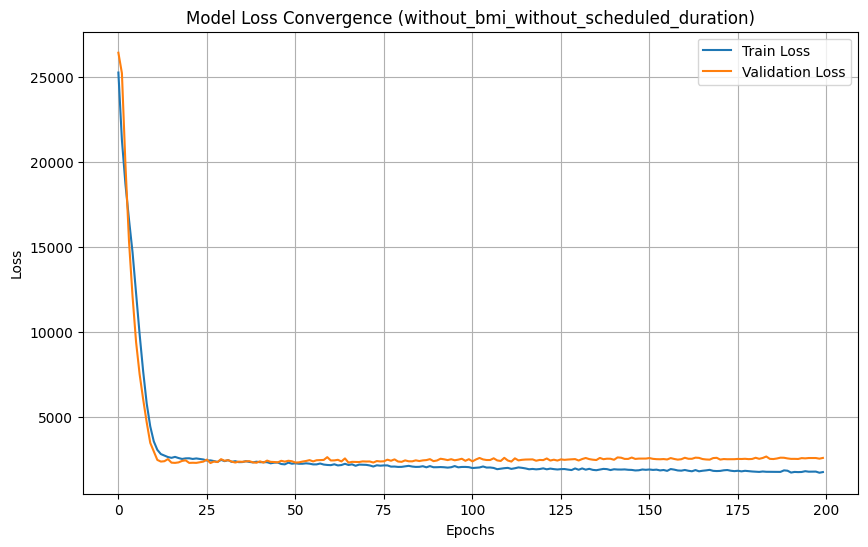

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [3]:
# Function to create the model
def create_model(trial, input_shape):
    model = Sequential()
    model.add(Dense(trial.suggest_int('units_l1', 64, 512), activation=trial.suggest_categorical('activation_l1', ['relu', 'elu', 'selu']), input_shape=(input_shape,)))
    model.add(BatchNormalization())
    model.add(Dropout(trial.suggest_float('dropout_l1', 0.2, 0.5)))

    for i in range(trial.suggest_int('n_layers', 2, 6)):
        model.add(Dense(trial.suggest_int(f'units_l{i+2}', 64, 512), activation=trial.suggest_categorical(f'activation_l{i+2}', ['relu', 'elu', 'selu'])))
        model.add(BatchNormalization())
        model.add(Dropout(trial.suggest_float(f'dropout_l{i+2}', 0.2, 0.5)))

    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=Adam(learning_rate=trial.suggest_float('lr', 1e-5, 1e-1, log=True)),
                  loss='mean_squared_error', 
                  metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])
    
    return model


def compare_columns(data, control_col, cols_to_compare, alpha=0.05, output_file='comparison_results.xlsx'):
    groups = [control_col] + cols_to_compare
    residuals = [data[col] for col in groups]

    # Create an Excel writer object
    writer = pd.ExcelWriter(output_file, engine='xlsxwriter')

    # Normality test
    normality_results = []
    for residual in residuals:
        stat, pvalue = shapiro(residual)
        normality_results.append((stat, pvalue, 'Normal' if pvalue > alpha else 'Not Normal'))

    # Create a DataFrame for normality test results
    normality_df = pd.DataFrame(normality_results, columns=['Statistic', 'p-value', 'Normality'], index=groups)
    normality_df['Decision'] = normality_df['p-value'].apply(lambda x: 'Normal' if x > alpha else 'Not Normal')

    # Save normality test results to Excel
    normality_df.to_excel(writer, sheet_name='Normality Test Results')

    # Check if all residuals are normally distributed
    if all(pvalue > alpha for _, pvalue, _ in normality_results):
        # One-way ANOVA
        anova_stat, anova_p = f_oneway(*residuals)
        test_name = "One-way ANOVA"
        test_decision = "Parametric test"
        explanation = "because the normality test results indicate that all columns are normally distributed."
    else:
        # Kruskal-Wallis test
        anova_stat, anova_p = kruskal(*residuals)
        test_name = "Kruskal-Wallis test"
        test_decision = "Non-parametric test"
        explanation = "because the normality test results indicate that at least one column is not normally distributed."

    # Create a DataFrame for overall test results
    overall_test_df = pd.DataFrame({
        'Test Name': [test_name],
        'Statistic': [anova_stat],
        'p-value': [anova_p],
        'Decision': [test_decision],
        'Explanation': [explanation],
        'Overall Result': ["There is a significant difference at least between one of the columns." if anova_p < alpha else "There is no significant difference between the columns."]
    })

    # Save overall test results to Excel
    overall_test_df.to_excel(writer, sheet_name='Overall Test Results', index=False)

    # Post-Hoc Tests
    if test_name == "One-way ANOVA" and anova_p < alpha:
        melted_data = pd.melt(data[groups], var_name='group', value_name='value')
        tukey_result = pairwise_tukeyhsd(melted_data['value'], melted_data['group'], alpha=alpha)
        tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])
        tukey_df['Decision'] = tukey_df['reject'].apply(lambda x: 'Significant' if x else 'Not Significant')

        # Save Tukey's HSD test results to Excel
        tukey_df.to_excel(writer, sheet_name="Tukey's HSD Test Results", index=False)
    elif test_name == "Kruskal-Wallis test" and anova_p < alpha:
        # Perform Mann-Whitney U test for pairwise comparison
        pairwise_results = []
        for i in range(len(groups)):
            for j in range(i + 1, len(groups)):
                stat, pvalue = mannwhitneyu(residuals[i], residuals[j])
                decision = "Significant" if pvalue < alpha else "Not Significant"
                pairwise_results.append((groups[i], groups[j], stat, pvalue, decision))

        # Create a DataFrame for pairwise Mann-Whitney U test results
        pairwise_df = pd.DataFrame(pairwise_results, columns=['Group 1', 'Group 2', 'U Statistic', 'p-value', 'Decision'])

        # Save pairwise Mann-Whitney U test results to Excel
        pairwise_df.to_excel(writer, sheet_name='Pairwise Mann-Whitney U Results', index=False)

    # Save and close the Excel file
    writer.close()

# Function to create and save plots
def create_plots(y_test, y_pred, title_suffix, pdf_pages):
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    # Round metrics to two decimal points
    mse = round(mse, 2)
    rmse = round(rmse, 2)
    mae = round(mae, 2)
    mape = round(mape, 2)
    r2 = round(r2, 2)

    # Visualize the results
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    axs[0, 0].scatter(y_test, y_pred, alpha=0.3)
    axs[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axs[0, 0].set_xlabel('True Values')
    axs[0, 0].set_ylabel('Predicted Values')
    axs[0, 0].set_title(f'True vs Predicted Values')

    sns.histplot(y_test - y_pred, bins=30, kde=True, ax=axs[0, 1])
    axs[0, 1].set_xlabel('Prediction Error')
    axs[0, 1].set_title(f'Prediction Error Distribution')

    sns.lineplot(x=range(len(y_test)), y=y_test, label='True Values', alpha=0.6, ax=axs[1, 0])
    sns.lineplot(x=range(len(y_test)), y=y_pred, label='Predicted Values', alpha=0.6, ax=axs[1, 0])
    axs[1, 0].set_xlabel('Samples')
    axs[1, 0].set_ylabel('Actual Case Time (minutes)')
    axs[1, 0].set_title(f'True vs Predicted Values Over Samples')
    axs[1, 0].legend()

    sns.boxplot(y=y_test - y_pred, ax=axs[1, 1])
    axs[1, 1].set_ylabel('Prediction Error')
    axs[1, 1].set_title(f'Boxplot of Prediction Error')

    # Add metrics as text
    fig.suptitle(f'{title_suffix} \n MSE: {mse}, RMSE: {rmse}, MAE: {mae}, MAPE: {mape}%, R²: {r2}', fontsize=12)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the suptitle

    # Save the current figure to the PDF file
    pdf_pages.savefig(fig)
    plt.close(fig)


# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Function to load data, train the model with best parameters, make predictions, and save the results
def train_model_with_best_params_and_predict(folder_name):
    # Define file paths
    base_dir = './data/'
    folder_path = os.path.join(base_dir, folder_name)
    
    # Load data
    X_train = pd.read_csv(os.path.join(folder_path, 'X_train.csv'), index_col=0)
    X_test = pd.read_csv(os.path.join(folder_path, 'X_test.csv'), index_col=0)
    y_train = pd.read_csv(os.path.join(folder_path, 'Y_train.csv'), index_col=0)
    y_test = pd.read_csv(os.path.join(folder_path, 'Y_test.csv'), index_col=0)
    
    input_shape = X_train.shape[1]

    # Load the best parameters
    with open(os.path.join(folder_path, 'bestparams.json'), 'r') as file:
        best_params = json.load(file)
    
    # Create and compile the model with the best parameters
    best_model = create_model(optuna.trial.FixedTrial(best_params), input_shape)

    # Fit the model and store the history
    history = best_model.fit(X_train, y_train, epochs=200, batch_size=best_params['batch_size'], 
                         validation_split=0.2, verbose=0) #, callbacks=[early_stopping])

    # Evaluate the model
    test_loss, test_mae, test_mape = best_model.evaluate(X_test, y_test, verbose=1)
    print(f'Test MAE for {folder_name}:', test_mae)
    print(f'Test MAPE for {folder_name}:', test_mape)

    # Save the evaluation results to a text file
    with open(os.path.join(folder_path, 'evaluation_results.txt'), 'w') as file:
        file.write(f'Test Loss: {test_loss}\n')
        file.write(f'Test MAE: {test_mae}\n')
        file.write(f'Test MAPE: {test_mape}\n')

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Model Loss Convergence ({folder_name})')
    plt.legend()
    plt.grid(True)

    # Save the plot to a PDF file
    plt.savefig(os.path.join(folder_path, 'loss_convergence.pdf'))

    # Show the plot
    plt.show()

    # Predict on the test set
    y_pred = best_model.predict(X_test).flatten()

    # Load the original dataframe
    result = pd.read_csv('./data/df_final.csv')
    result.set_index(result.columns[0], inplace=True)
    
    # Ensure the index matches the test data index
    result = result.loc[X_test.index]

    # Add the predictions to the DataFrame
    result['Prediction'] = y_pred

    # Reorder the DataFrame columns
    cols = list(result.columns)
    cols.remove('actual_casetime_minutes')
    cols.append('actual_casetime_minutes')
    result = result[cols]

    # Add the predictions and residuals to the DataFrame
    result['Prediction'] = y_pred

    # Reorder the DataFrame columns
    cols = list(result.columns)
    cols.remove('scheduled_duration')
    cols.remove('Prediction')
    cols.remove('actual_casetime_minutes')
    cols.extend(['scheduled_duration', 'Prediction', 'actual_casetime_minutes'])
    result = result[cols]

    # Save the results
    result.to_csv(os.path.join(folder_path, 'predictions.csv'), index=True)

    compare_columns(data=result, control_col= 'actual_casetime_minutes', cols_to_compare=['scheduled_duration', 'Prediction'], alpha=0.05, output_file= os.path.join(folder_path, 'comparison_results.xlsx'))
    
    # Create the Plotly figure
    fig = go.Figure()

    # Add traces for each column
    fig.add_trace(go.Scatter(x=list(range(len(result))), y=result['Prediction'], mode='lines', name='Prediction', line=dict(color='#a83242')))
    fig.add_trace(go.Scatter(x=list(range(len(result))), y=result['scheduled_duration'], mode='lines', name='Scheduled Duration', line=dict(color='#32a852')))
    fig.add_trace(go.Scatter(x=list(range(len(result))), y=result['actual_casetime_minutes'], mode='lines', name='Actual Case Time', line=dict(color='#4287f5')))

    # Update layout
    fig.update_layout(
        title=f'Predictions vs Scheduled Duration vs Actual Case Time ({folder_name})',
        xaxis_title='Samples',
        yaxis_title='Time (minutes)',
        legend=dict(x=0.1, y=1.1, orientation='h'),
        hovermode='closest',
        plot_bgcolor='white',  # Remove background color
        paper_bgcolor='white'  # Remove paper background color
    )

    # Customize grid and axis lines
    fig.update_xaxes(showgrid=False, gridwidth=1, gridcolor='lightgray')
    fig.update_yaxes(showgrid=False, gridwidth=1, gridcolor='lightgray')

    # Save the Plotly figure to HTML
    pio.write_html(fig, file=os.path.join(folder_path, 'predictions.html'), auto_open=True)

    # Save both sets of plots to a single PDF file
    with PdfPages(os.path.join(folder_path, 'evaluation_plots.pdf')) as pdf_pages:
        # Plot for Prediction vs actual_casetime_minutes
        create_plots(result['actual_casetime_minutes'], result['Prediction'], f'{folder_name} Prediction vs Actual Case Time', pdf_pages)
        
        # Plot for scheduled_duration vs actual_casetime_minutes
        create_plots(result['actual_casetime_minutes'], result['scheduled_duration'], f'{folder_name} Scheduled Duration vs Actual Case Time', pdf_pages)
    
    # Compute and plot SHAP values
    # compute_and_plot_shap_values(best_model, X_train, folder_path)
    return best_model

# Define the list of scenarios
scenarios = [
    'with_bmi_with_scheduled_duration',
    'with_bmi_without_scheduled_duration',
    'without_bmi_with_scheduled_duration',
    'without_bmi_without_scheduled_duration'
]

# Initialize an empty dictionary to store the best models
best_models = {}

# Train the model with best parameters and predict for each scenario
for scenario in scenarios:
    best_model = train_model_with_best_params_and_predict(scenario)
    best_models[scenario] = best_model


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  1%|          | 1/100 [00:01<02:12,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step


  2%|▏         | 2/100 [00:02<01:39,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step


  3%|▎         | 3/100 [00:02<01:28,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step


  4%|▍         | 4/100 [00:03<01:23,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step


  5%|▌         | 5/100 [00:04<01:19,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


  6%|▌         | 6/100 [00:05<01:17,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step


  7%|▋         | 7/100 [00:06<01:16,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step


  8%|▊         | 8/100 [00:06<01:14,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step


  9%|▉         | 9/100 [00:07<01:13,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step


 10%|█         | 10/100 [00:08<01:12,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step


 11%|█         | 11/100 [00:09<01:11,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step


 12%|█▏        | 12/100 [00:10<01:10,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step


 13%|█▎        | 13/100 [00:10<01:09,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step


 14%|█▍        | 14/100 [00:11<01:08,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step


 15%|█▌        | 15/100 [00:12<01:07,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step


 16%|█▌        | 16/100 [00:13<01:06,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step


 17%|█▋        | 17/100 [00:14<01:05,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step


 18%|█▊        | 18/100 [00:14<01:05,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step


 19%|█▉        | 19/100 [00:15<01:04,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step


 20%|██        | 20/100 [00:16<01:03,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step


 21%|██        | 21/100 [00:17<01:02,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step


 22%|██▏       | 22/100 [00:18<01:01,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step


 23%|██▎       | 23/100 [00:18<01:00,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step


 24%|██▍       | 24/100 [00:19<01:00,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step


 25%|██▌       | 25/100 [00:20<00:59,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step


 26%|██▌       | 26/100 [00:21<00:58,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step


 27%|██▋       | 27/100 [00:21<00:57,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step


 28%|██▊       | 28/100 [00:22<00:57,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step


 29%|██▉       | 29/100 [00:23<00:56,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step


 30%|███       | 30/100 [00:24<00:55,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step


 31%|███       | 31/100 [00:25<00:54,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step


 32%|███▏      | 32/100 [00:25<00:53,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step


 33%|███▎      | 33/100 [00:26<00:53,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step


 34%|███▍      | 34/100 [00:27<00:52,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


 35%|███▌      | 35/100 [00:28<00:51,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step


 36%|███▌      | 36/100 [00:29<00:50,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step


 37%|███▋      | 37/100 [00:29<00:49,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step


 38%|███▊      | 38/100 [00:30<00:49,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step


 39%|███▉      | 39/100 [00:31<00:49,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step


 40%|████      | 40/100 [00:32<00:48,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step


 41%|████      | 41/100 [00:33<00:47,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


 42%|████▏     | 42/100 [00:33<00:46,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step


 43%|████▎     | 43/100 [00:34<00:46,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


 44%|████▍     | 44/100 [00:35<00:46,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step


 45%|████▌     | 45/100 [00:36<00:45,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step


 46%|████▌     | 46/100 [00:37<00:43,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step


 47%|████▋     | 47/100 [00:38<00:42,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step


 48%|████▊     | 48/100 [00:38<00:42,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


 49%|████▉     | 49/100 [00:39<00:41,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step


 50%|█████     | 50/100 [00:40<00:40,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step


 51%|█████     | 51/100 [00:41<00:39,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step


 52%|█████▏    | 52/100 [00:42<00:38,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step


 53%|█████▎    | 53/100 [00:42<00:37,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step


 54%|█████▍    | 54/100 [00:43<00:36,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step


 55%|█████▌    | 55/100 [00:44<00:36,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step


 56%|█████▌    | 56/100 [00:45<00:35,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step


 57%|█████▋    | 57/100 [00:46<00:34,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step


 58%|█████▊    | 58/100 [00:47<00:34,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step


 59%|█████▉    | 59/100 [00:47<00:34,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step


 60%|██████    | 60/100 [00:49<00:39,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step


 61%|██████    | 61/100 [00:50<00:36,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step


 62%|██████▏   | 62/100 [00:50<00:33,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step


 63%|██████▎   | 63/100 [00:51<00:31,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step


 64%|██████▍   | 64/100 [00:52<00:30,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step


 65%|██████▌   | 65/100 [00:53<00:29,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step


 66%|██████▌   | 66/100 [00:54<00:28,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step


 67%|██████▋   | 67/100 [00:54<00:26,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step


 68%|██████▊   | 68/100 [00:55<00:26,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step


 69%|██████▉   | 69/100 [00:56<00:25,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step


 70%|███████   | 70/100 [00:57<00:24,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step


 71%|███████   | 71/100 [00:58<00:23,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step


 72%|███████▏  | 72/100 [00:58<00:22,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step


 73%|███████▎  | 73/100 [00:59<00:21,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step


 74%|███████▍  | 74/100 [01:00<00:20,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step


 75%|███████▌  | 75/100 [01:01<00:20,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step


 76%|███████▌  | 76/100 [01:02<00:19,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step


 77%|███████▋  | 77/100 [01:02<00:18,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step


 78%|███████▊  | 78/100 [01:03<00:17,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step


 79%|███████▉  | 79/100 [01:04<00:16,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step


 80%|████████  | 80/100 [01:05<00:16,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step


 81%|████████  | 81/100 [01:06<00:15,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step


 82%|████████▏ | 82/100 [01:06<00:14,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step


 83%|████████▎ | 83/100 [01:07<00:13,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step


 84%|████████▍ | 84/100 [01:08<00:12,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step


 85%|████████▌ | 85/100 [01:09<00:12,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step


 86%|████████▌ | 86/100 [01:10<00:11,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step


 87%|████████▋ | 87/100 [01:10<00:10,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step


 88%|████████▊ | 88/100 [01:11<00:09,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step


 89%|████████▉ | 89/100 [01:12<00:08,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step


 90%|█████████ | 90/100 [01:13<00:07,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step


 91%|█████████ | 91/100 [01:14<00:07,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step


 92%|█████████▏| 92/100 [01:14<00:06,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step


 93%|█████████▎| 93/100 [01:15<00:05,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step


 94%|█████████▍| 94/100 [01:16<00:04,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step


 95%|█████████▌| 95/100 [01:17<00:03,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step


 96%|█████████▌| 96/100 [01:18<00:03,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step


 97%|█████████▋| 97/100 [01:18<00:02,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step


 98%|█████████▊| 98/100 [01:19<00:01,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step


 99%|█████████▉| 99/100 [01:20<00:00,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step


100%|██████████| 100/100 [01:21<00:00,  1.23it/s]
/tmp/ipykernel_2624718/1078903474.py:34: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




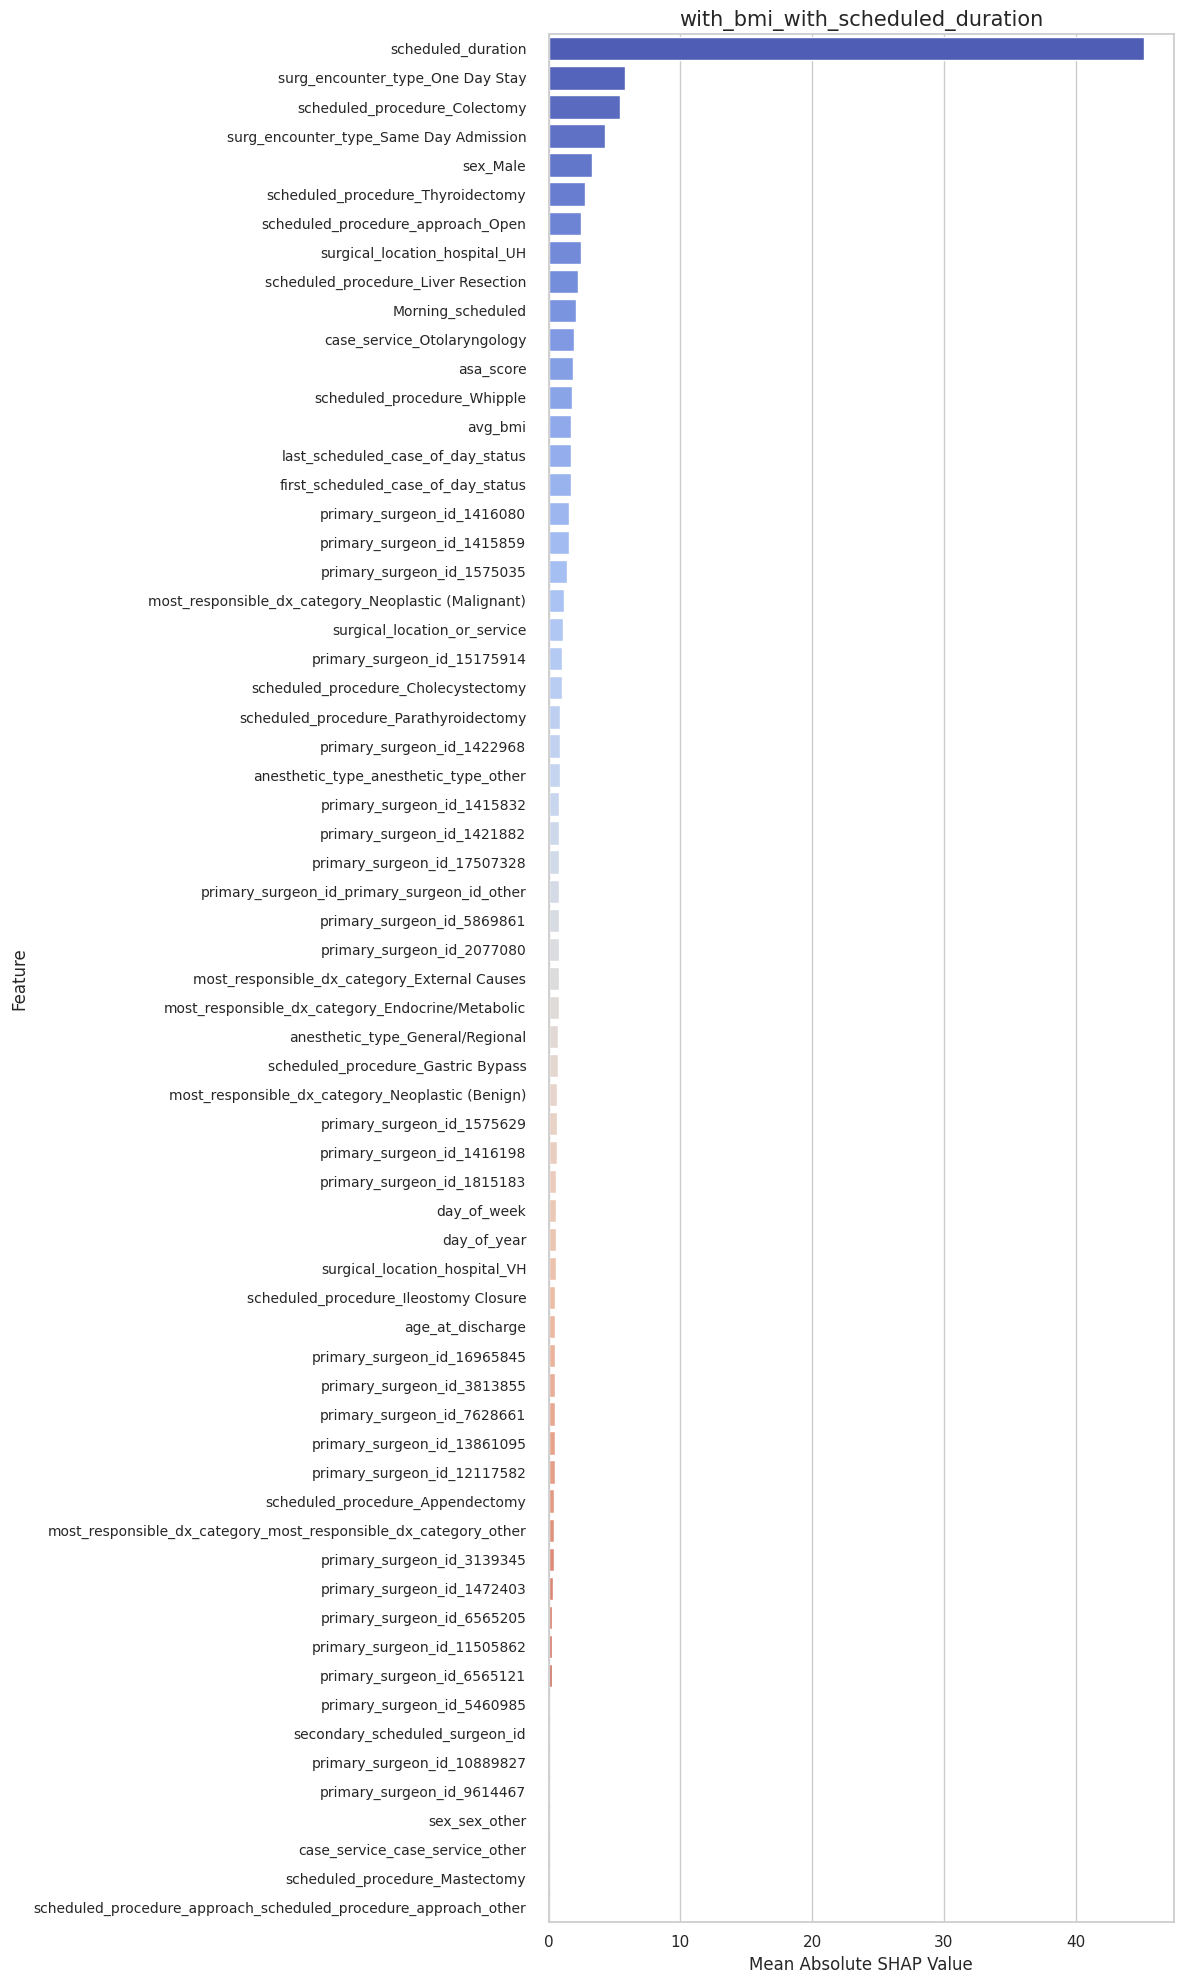

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


  1%|          | 1/100 [00:01<02:28,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  2%|▏         | 2/100 [00:02<01:49,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  3%|▎         | 3/100 [00:03<01:36,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  4%|▍         | 4/100 [00:04<01:29,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  5%|▌         | 5/100 [00:04<01:25,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  6%|▌         | 6/100 [00:05<01:23,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  7%|▋         | 7/100 [00:06<01:21,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  8%|▊         | 8/100 [00:07<01:19,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  9%|▉         | 9/100 [00:08<01:20,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 10%|█         | 10/100 [00:09<01:18,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 11%|█         | 11/100 [00:10<01:16,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 12%|█▏        | 12/100 [00:10<01:15,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 13%|█▎        | 13/100 [00:11<01:14,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 14%|█▍        | 14/100 [00:12<01:12,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 15%|█▌        | 15/100 [00:13<01:13,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 16%|█▌        | 16/100 [00:14<01:13,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 17%|█▋        | 17/100 [00:15<01:12,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 18%|█▊        | 18/100 [00:16<01:10,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 19%|█▉        | 19/100 [00:16<01:09,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 20%|██        | 20/100 [00:17<01:08,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 21%|██        | 21/100 [00:18<01:07,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 22%|██▏       | 22/100 [00:19<01:06,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 23%|██▎       | 23/100 [00:20<01:05,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 24%|██▍       | 24/100 [00:21<01:04,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 25%|██▌       | 25/100 [00:21<01:03,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 26%|██▌       | 26/100 [00:22<01:02,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 27%|██▋       | 27/100 [00:23<01:02,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 28%|██▊       | 28/100 [00:24<01:02,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 29%|██▉       | 29/100 [00:25<01:02,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 30%|███       | 30/100 [00:26<01:00,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 31%|███       | 31/100 [00:27<00:59,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 32%|███▏      | 32/100 [00:28<00:57,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 33%|███▎      | 33/100 [00:28<00:56,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 34%|███▍      | 34/100 [00:29<00:55,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 35%|███▌      | 35/100 [00:30<00:54,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 36%|███▌      | 36/100 [00:31<00:53,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 37%|███▋      | 37/100 [00:32<00:52,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 38%|███▊      | 38/100 [00:33<00:52,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 39%|███▉      | 39/100 [00:33<00:51,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 40%|████      | 40/100 [00:34<00:50,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 41%|████      | 41/100 [00:35<00:50,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 42%|████▏     | 42/100 [00:36<00:49,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 43%|████▎     | 43/100 [00:37<00:49,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 44%|████▍     | 44/100 [00:38<00:48,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 45%|████▌     | 45/100 [00:39<00:48,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 46%|████▌     | 46/100 [00:40<00:47,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 47%|████▋     | 47/100 [00:40<00:45,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 48%|████▊     | 48/100 [00:41<00:44,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 49%|████▉     | 49/100 [00:42<00:43,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 50%|█████     | 50/100 [00:43<00:42,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 51%|█████     | 51/100 [00:44<00:41,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 52%|█████▏    | 52/100 [00:45<00:40,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 53%|█████▎    | 53/100 [00:45<00:39,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 54%|█████▍    | 54/100 [00:46<00:38,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 55%|█████▌    | 55/100 [00:47<00:38,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 56%|█████▌    | 56/100 [00:48<00:37,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 57%|█████▋    | 57/100 [00:49<00:37,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 58%|█████▊    | 58/100 [00:50<00:37,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 59%|█████▉    | 59/100 [00:51<00:36,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 60%|██████    | 60/100 [00:52<00:35,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 61%|██████    | 61/100 [00:52<00:33,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 62%|██████▏   | 62/100 [00:53<00:32,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 63%|██████▎   | 63/100 [00:54<00:32,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 64%|██████▍   | 64/100 [00:55<00:32,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 65%|██████▌   | 65/100 [00:56<00:31,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 66%|██████▌   | 66/100 [00:57<00:30,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 67%|██████▋   | 67/100 [00:58<00:29,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 68%|██████▊   | 68/100 [00:59<00:27,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 69%|██████▉   | 69/100 [00:59<00:26,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 70%|███████   | 70/100 [01:00<00:25,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 71%|███████   | 71/100 [01:01<00:24,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 72%|███████▏  | 72/100 [01:02<00:23,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 73%|███████▎  | 73/100 [01:03<00:22,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 74%|███████▍  | 74/100 [01:04<00:22,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 75%|███████▌  | 75/100 [01:05<00:21,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 76%|███████▌  | 76/100 [01:06<00:21,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/lustre03/project/6010096/moenoor/myenv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 47 iterations, alpha=3.787e-02, previous alpha=3.031e-02, with an active set of 34 regressors.

 77%|███████▋  | 77/100 [01:07<00:20,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 78%|███████▊  | 78/100 [01:07<00:19,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 79%|███████▉  | 79/100 [01:08<00:18,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 80%|████████  | 80/100 [01:09<00:17,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 81%|████████  | 81/100 [01:10<00:16,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 82%|████████▏ | 82/100 [01:11<00:15,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 83%|████████▎ | 83/100 [01:12<00:14,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 84%|████████▍ | 84/100 [01:13<00:13,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 85%|████████▌ | 85/100 [01:13<00:12,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 86%|████████▌ | 86/100 [01:14<00:11,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 87%|████████▋ | 87/100 [01:15<00:11,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 88%|████████▊ | 88/100 [01:16<00:10,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 89%|████████▉ | 89/100 [01:17<00:09,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 90%|█████████ | 90/100 [01:18<00:09,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 91%|█████████ | 91/100 [01:19<00:08,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 92%|█████████▏| 92/100 [01:20<00:07,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 93%|█████████▎| 93/100 [01:20<00:06,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 94%|█████████▍| 94/100 [01:21<00:05,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 95%|█████████▌| 95/100 [01:22<00:04,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 96%|█████████▌| 96/100 [01:23<00:03,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 97%|█████████▋| 97/100 [01:24<00:02,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 98%|█████████▊| 98/100 [01:25<00:01,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 99%|█████████▉| 99/100 [01:26<00:00,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
/tmp/ipykernel_2624718/1078903474.py:34: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




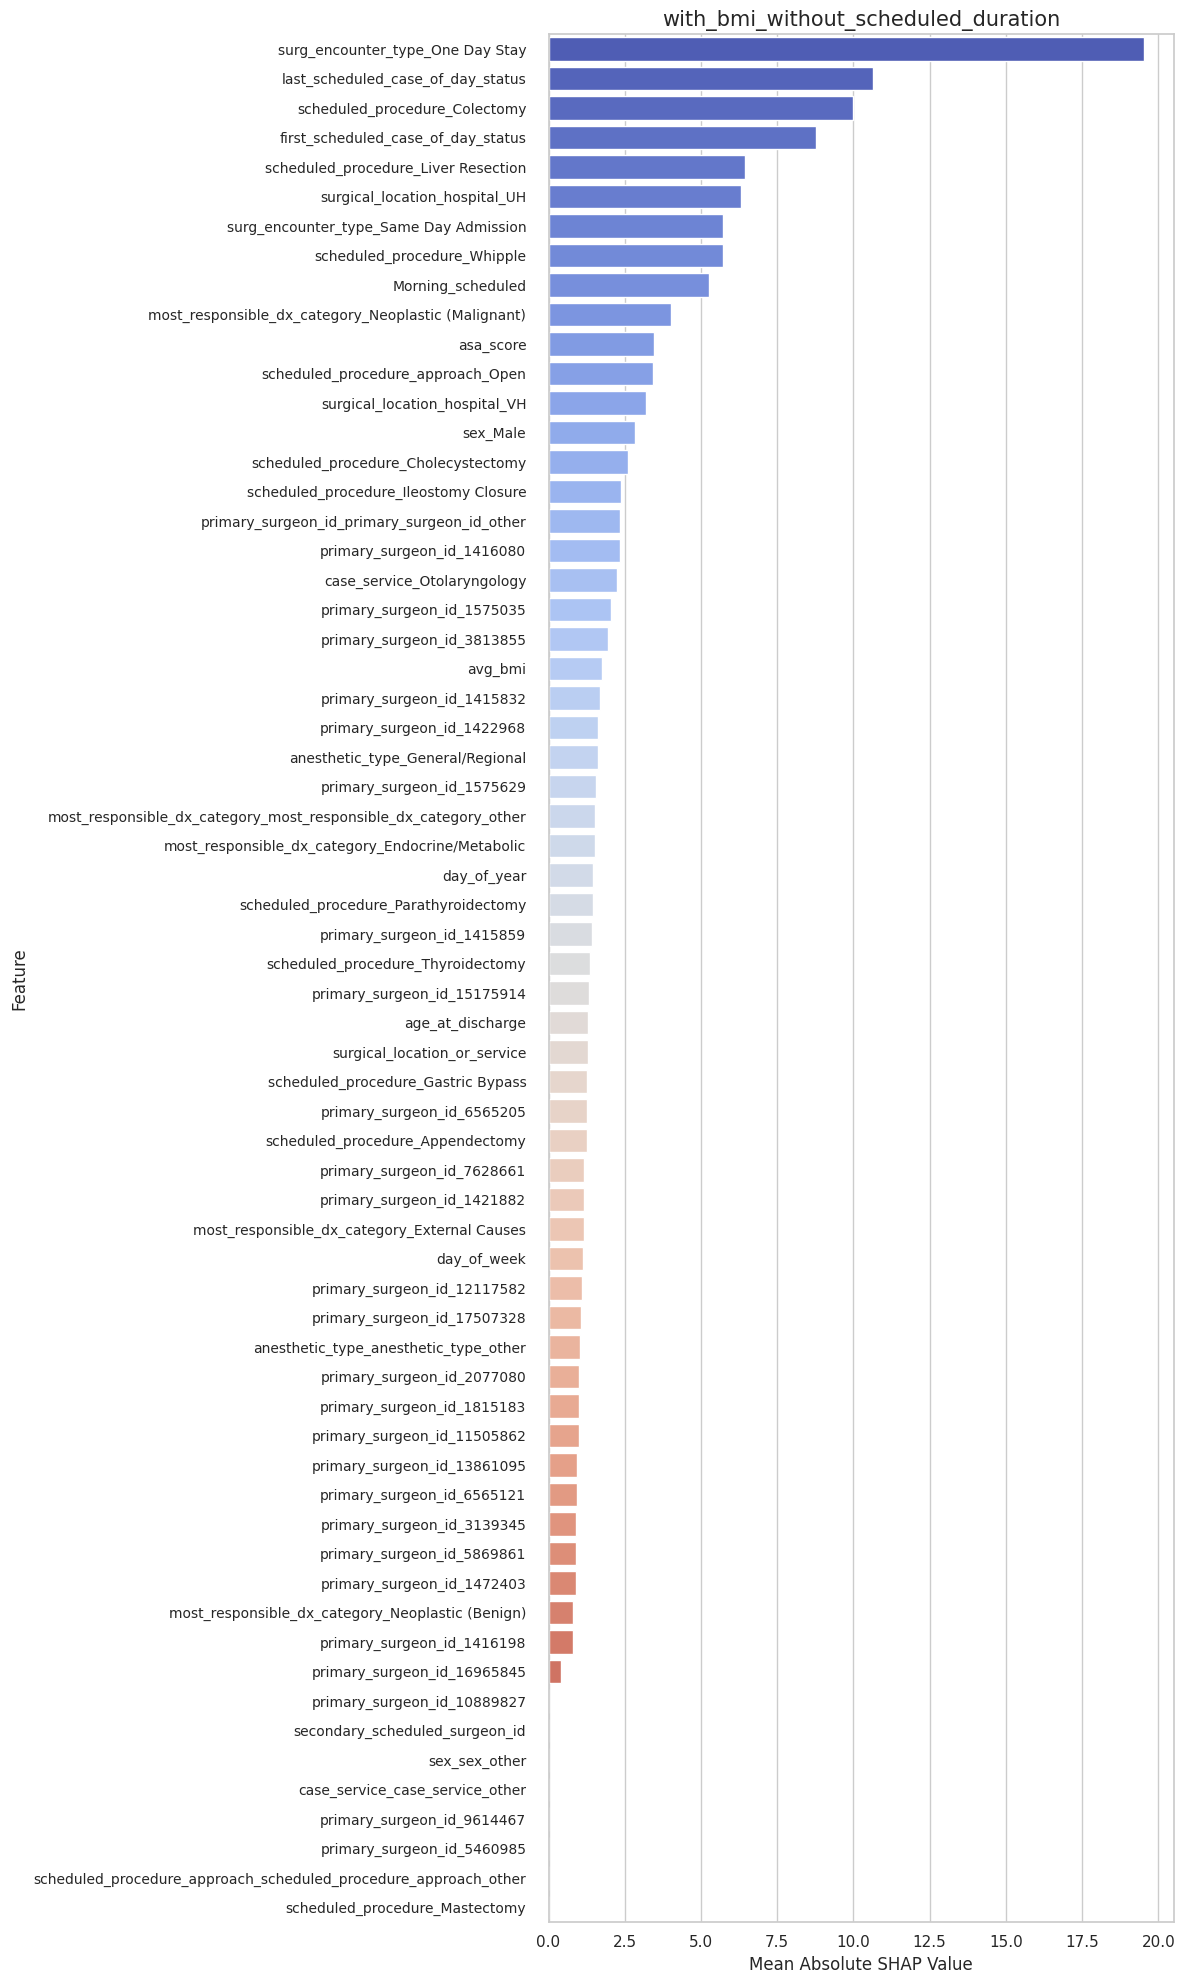

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 1/100 [00:01<02:01,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step


  2%|▏         | 2/100 [00:02<01:35,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step


  3%|▎         | 3/100 [00:02<01:26,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step


  4%|▍         | 4/100 [00:03<01:21,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step


  5%|▌         | 5/100 [00:04<01:18,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step


  6%|▌         | 6/100 [00:05<01:16,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step


  7%|▋         | 7/100 [00:05<01:15,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step


  8%|▊         | 8/100 [00:06<01:14,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step


  9%|▉         | 9/100 [00:07<01:13,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step


 10%|█         | 10/100 [00:08<01:11,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step


 11%|█         | 11/100 [00:09<01:10,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step


 12%|█▏        | 12/100 [00:09<01:09,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step


 13%|█▎        | 13/100 [00:10<01:09,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step


 14%|█▍        | 14/100 [00:11<01:08,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step


 15%|█▌        | 15/100 [00:12<01:07,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step


 16%|█▌        | 16/100 [00:13<01:07,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step


 17%|█▋        | 17/100 [00:13<01:06,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step


 18%|█▊        | 18/100 [00:14<01:05,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step


 19%|█▉        | 19/100 [00:15<01:05,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step


 20%|██        | 20/100 [00:16<01:04,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step


 21%|██        | 21/100 [00:17<01:03,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step


 22%|██▏       | 22/100 [00:17<01:02,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step


 23%|██▎       | 23/100 [00:18<01:01,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step


 24%|██▍       | 24/100 [00:19<01:00,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


 25%|██▌       | 25/100 [00:20<00:59,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step


 26%|██▌       | 26/100 [00:21<00:59,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step


 27%|██▋       | 27/100 [00:21<00:58,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step


 28%|██▊       | 28/100 [00:22<00:57,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step


 29%|██▉       | 29/100 [00:23<00:58,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step


 30%|███       | 30/100 [00:24<00:56,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step


 31%|███       | 31/100 [00:25<00:55,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step


 32%|███▏      | 32/100 [00:26<00:55,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step


 33%|███▎      | 33/100 [00:26<00:55,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step


 34%|███▍      | 34/100 [00:27<00:53,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step


 35%|███▌      | 35/100 [00:28<00:52,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step


 36%|███▌      | 36/100 [00:29<00:51,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step


 37%|███▋      | 37/100 [00:30<00:51,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step


 38%|███▊      | 38/100 [00:30<00:50,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step


 39%|███▉      | 39/100 [00:31<00:49,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step


 40%|████      | 40/100 [00:32<00:48,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step


 41%|████      | 41/100 [00:33<00:48,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step


 42%|████▏     | 42/100 [00:34<00:47,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step


 43%|████▎     | 43/100 [00:34<00:45,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step


 44%|████▍     | 44/100 [00:35<00:44,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step


 45%|████▌     | 45/100 [00:36<00:44,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step


 46%|████▌     | 46/100 [00:37<00:43,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step


 47%|████▋     | 47/100 [00:38<00:42,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step


 48%|████▊     | 48/100 [00:38<00:41,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step


 49%|████▉     | 49/100 [00:39<00:41,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step


 50%|█████     | 50/100 [00:40<00:40,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step


 51%|█████     | 51/100 [00:41<00:39,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step


 52%|█████▏    | 52/100 [00:42<00:38,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step


 53%|█████▎    | 53/100 [00:42<00:37,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step


 54%|█████▍    | 54/100 [00:43<00:36,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step


 55%|█████▌    | 55/100 [00:44<00:36,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step


 56%|█████▌    | 56/100 [00:45<00:35,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step


 57%|█████▋    | 57/100 [00:46<00:34,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step


 58%|█████▊    | 58/100 [00:46<00:33,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step


 59%|█████▉    | 59/100 [00:47<00:32,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step


 60%|██████    | 60/100 [00:48<00:31,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step


 61%|██████    | 61/100 [00:49<00:31,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step


 62%|██████▏   | 62/100 [00:50<00:30,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step


 63%|██████▎   | 63/100 [00:50<00:29,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step


 64%|██████▍   | 64/100 [00:51<00:28,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step


 65%|██████▌   | 65/100 [00:52<00:27,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step


 66%|██████▌   | 66/100 [00:53<00:27,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step


 67%|██████▋   | 67/100 [00:54<00:26,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step


 68%|██████▊   | 68/100 [00:55<00:27,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step


 69%|██████▉   | 69/100 [00:55<00:26,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


 70%|███████   | 70/100 [00:56<00:24,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step


 71%|███████   | 71/100 [00:57<00:23,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step


 72%|███████▏  | 72/100 [00:58<00:22,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step


 73%|███████▎  | 73/100 [00:59<00:21,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step


 74%|███████▍  | 74/100 [00:59<00:20,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step


 75%|███████▌  | 75/100 [01:00<00:20,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step


 76%|███████▌  | 76/100 [01:01<00:19,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step


 77%|███████▋  | 77/100 [01:02<00:18,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step


 78%|███████▊  | 78/100 [01:03<00:17,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step


 79%|███████▉  | 79/100 [01:03<00:16,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step


 80%|████████  | 80/100 [01:04<00:15,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step


 81%|████████  | 81/100 [01:05<00:15,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step


 82%|████████▏ | 82/100 [01:06<00:14,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step


 83%|████████▎ | 83/100 [01:07<00:13,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step


 84%|████████▍ | 84/100 [01:07<00:12,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step


 85%|████████▌ | 85/100 [01:08<00:11,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step


 86%|████████▌ | 86/100 [01:09<00:11,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step


 87%|████████▋ | 87/100 [01:10<00:10,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step


 88%|████████▊ | 88/100 [01:11<00:09,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step


 89%|████████▉ | 89/100 [01:11<00:08,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step


 90%|█████████ | 90/100 [01:12<00:08,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step


 91%|█████████ | 91/100 [01:13<00:07,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step


 92%|█████████▏| 92/100 [01:14<00:06,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step


 93%|█████████▎| 93/100 [01:15<00:05,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step


 94%|█████████▍| 94/100 [01:15<00:04,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step


 95%|█████████▌| 95/100 [01:16<00:03,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step


 96%|█████████▌| 96/100 [01:17<00:03,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step


 97%|█████████▋| 97/100 [01:18<00:02,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step


 98%|█████████▊| 98/100 [01:19<00:01,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step


 99%|█████████▉| 99/100 [01:19<00:00,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step


100%|██████████| 100/100 [01:20<00:00,  1.24it/s]
/tmp/ipykernel_2624718/1078903474.py:34: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




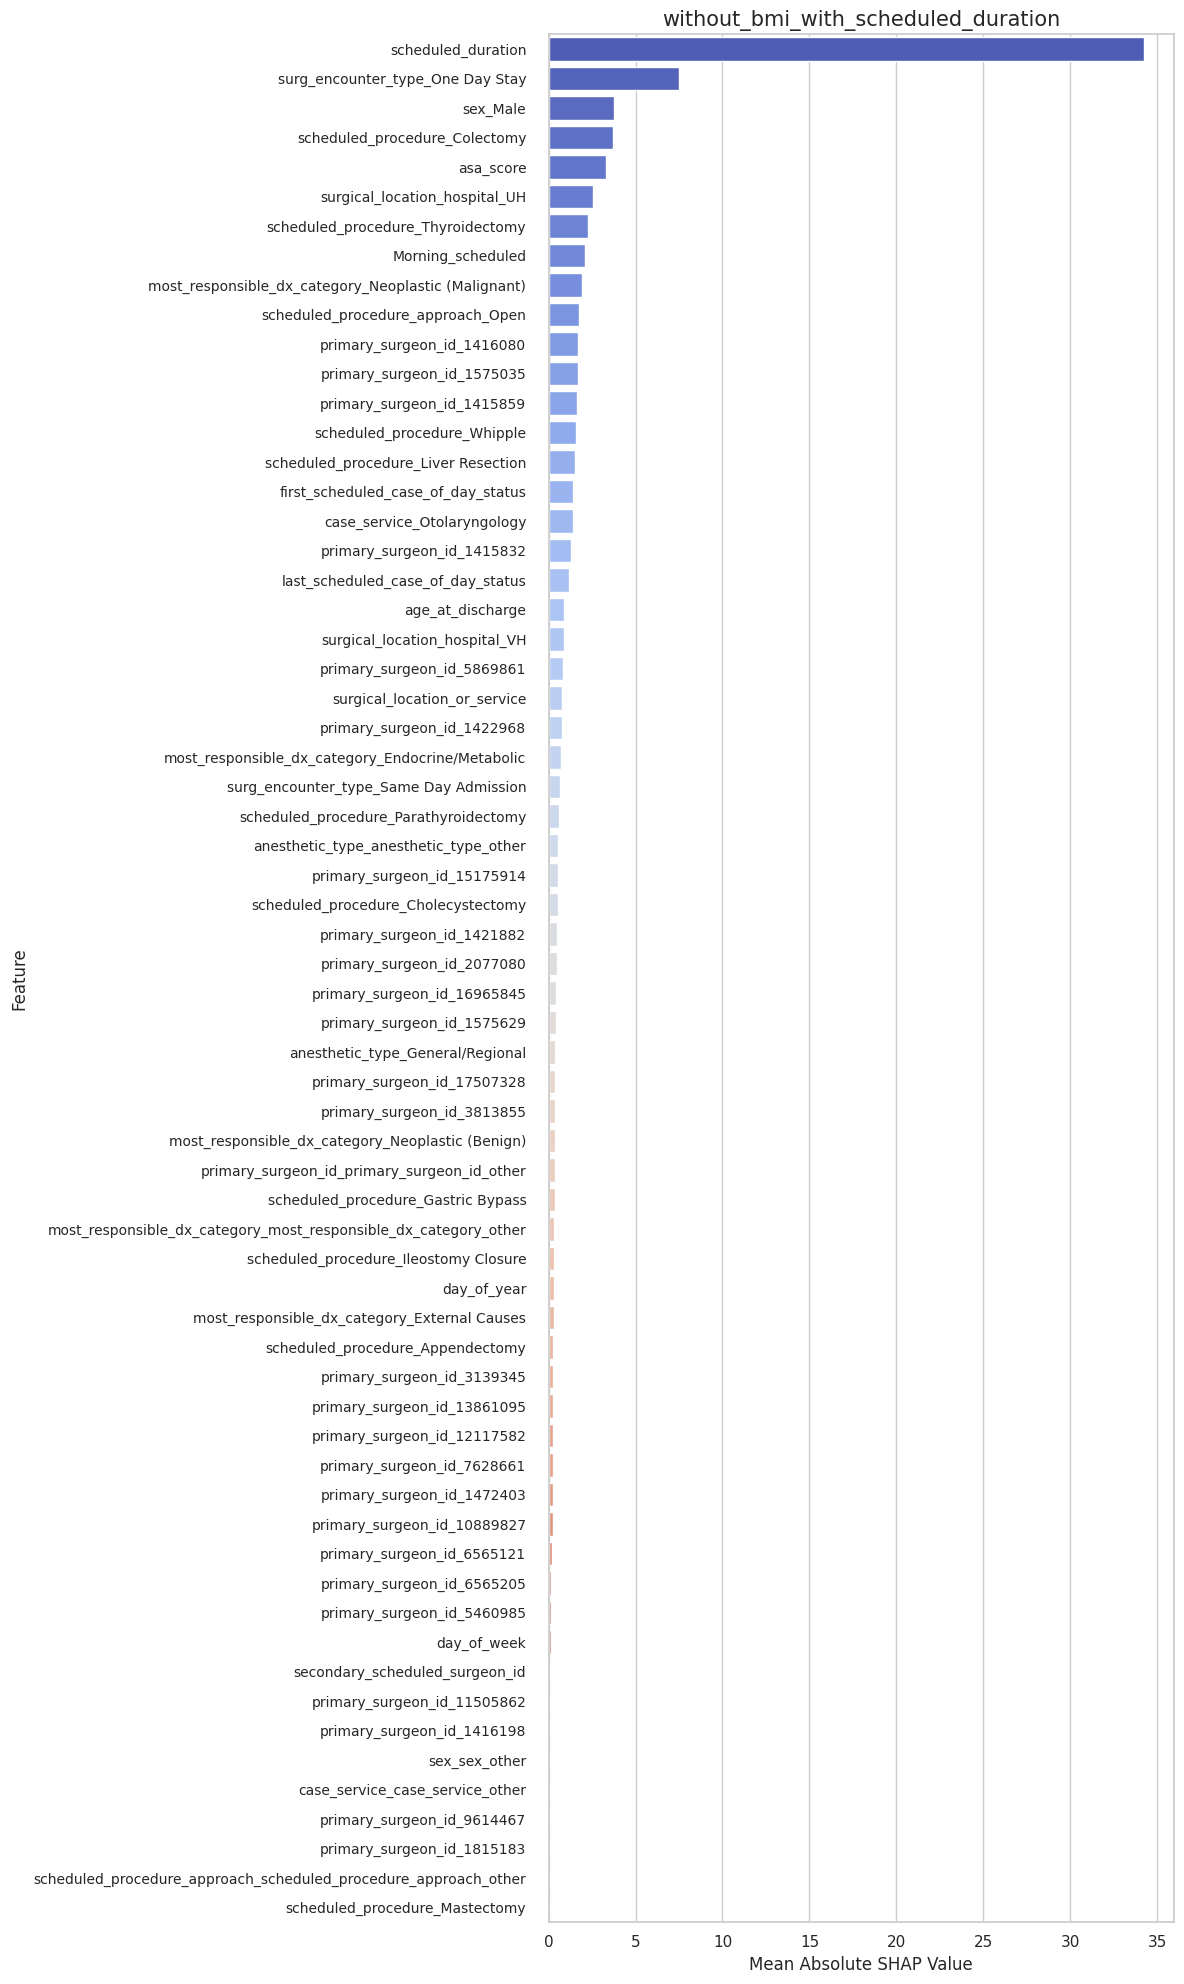

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


  1%|          | 1/100 [00:01<02:05,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step


  2%|▏         | 2/100 [00:02<01:37,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step


  3%|▎         | 3/100 [00:02<01:28,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step


  4%|▍         | 4/100 [00:03<01:25,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step


  5%|▌         | 5/100 [00:04<01:23,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step


  6%|▌         | 6/100 [00:05<01:20,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step


  7%|▋         | 7/100 [00:06<01:17,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step


  8%|▊         | 8/100 [00:06<01:15,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step


  9%|▉         | 9/100 [00:07<01:14,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step


 10%|█         | 10/100 [00:08<01:13,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   


 11%|█         | 11/100 [00:09<01:14,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step


 12%|█▏        | 12/100 [00:10<01:13,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step


 13%|█▎        | 13/100 [00:11<01:11,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step


 14%|█▍        | 14/100 [00:11<01:10,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step


 15%|█▌        | 15/100 [00:12<01:09,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step


 16%|█▌        | 16/100 [00:13<01:08,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step


 17%|█▋        | 17/100 [00:14<01:07,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step


 18%|█▊        | 18/100 [00:15<01:05,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


 19%|█▉        | 19/100 [00:15<01:05,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step


 20%|██        | 20/100 [00:16<01:04,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step


 21%|██        | 21/100 [00:17<01:03,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step


 22%|██▏       | 22/100 [00:18<01:03,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step


 23%|██▎       | 23/100 [00:19<01:03,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step


 24%|██▍       | 24/100 [00:20<01:02,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step


 25%|██▌       | 25/100 [00:20<01:00,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step


 26%|██▌       | 26/100 [00:21<00:59,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step


 27%|██▋       | 27/100 [00:22<00:58,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   


 28%|██▊       | 28/100 [00:23<00:58,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step


 29%|██▉       | 29/100 [00:24<00:57,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step


 30%|███       | 30/100 [00:24<00:56,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step


 31%|███       | 31/100 [00:25<00:55,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step


 32%|███▏      | 32/100 [00:26<00:54,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step


 33%|███▎      | 33/100 [00:27<00:53,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step


 34%|███▍      | 34/100 [00:28<00:52,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step


 35%|███▌      | 35/100 [00:28<00:52,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step


 36%|███▌      | 36/100 [00:29<00:51,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step


 37%|███▋      | 37/100 [00:30<00:50,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step


 38%|███▊      | 38/100 [00:31<00:50,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step


 39%|███▉      | 39/100 [00:32<00:51,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step


 40%|████      | 40/100 [00:33<00:49,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step


 41%|████      | 41/100 [00:33<00:48,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step


 42%|████▏     | 42/100 [00:34<00:47,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step


 43%|████▎     | 43/100 [00:35<00:46,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step


 44%|████▍     | 44/100 [00:36<00:45,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step


 45%|████▌     | 45/100 [00:37<00:44,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step


 46%|████▌     | 46/100 [00:37<00:43,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step


 47%|████▋     | 47/100 [00:38<00:42,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step


 48%|████▊     | 48/100 [00:39<00:41,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step


 49%|████▉     | 49/100 [00:40<00:41,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step


 50%|█████     | 50/100 [00:41<00:40,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step


 51%|█████     | 51/100 [00:41<00:39,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


 52%|█████▏    | 52/100 [00:42<00:38,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step


 53%|█████▎    | 53/100 [00:43<00:37,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step


 54%|█████▍    | 54/100 [00:44<00:36,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


 55%|█████▌    | 55/100 [00:45<00:36,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step


 56%|█████▌    | 56/100 [00:45<00:35,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step


 57%|█████▋    | 57/100 [00:46<00:34,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step


 58%|█████▊    | 58/100 [00:47<00:34,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


 59%|█████▉    | 59/100 [00:48<00:33,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step


 60%|██████    | 60/100 [00:49<00:32,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


 61%|██████    | 61/100 [00:49<00:31,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step


 62%|██████▏   | 62/100 [00:50<00:31,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step


 63%|██████▎   | 63/100 [00:51<00:30,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step


 64%|██████▍   | 64/100 [00:52<00:29,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step


 65%|██████▌   | 65/100 [00:53<00:28,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


 66%|██████▌   | 66/100 [00:54<00:27,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step


 67%|██████▋   | 67/100 [00:54<00:26,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step


 68%|██████▊   | 68/100 [00:55<00:25,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step


 69%|██████▉   | 69/100 [00:56<00:25,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step


 70%|███████   | 70/100 [00:57<00:24,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step


 71%|███████   | 71/100 [00:58<00:23,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step


 72%|███████▏  | 72/100 [00:58<00:22,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step


 73%|███████▎  | 73/100 [00:59<00:21,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step


 74%|███████▍  | 74/100 [01:00<00:20,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step


 75%|███████▌  | 75/100 [01:01<00:20,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step


 76%|███████▌  | 76/100 [01:02<00:19,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step


 77%|███████▋  | 77/100 [01:02<00:18,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step


 78%|███████▊  | 78/100 [01:03<00:17,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step


 79%|███████▉  | 79/100 [01:04<00:16,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


 80%|████████  | 80/100 [01:05<00:16,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step


 81%|████████  | 81/100 [01:06<00:15,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step


 82%|████████▏ | 82/100 [01:06<00:14,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step


 83%|████████▎ | 83/100 [01:07<00:13,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step


 84%|████████▍ | 84/100 [01:08<00:12,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 85%|████████▌ | 85/100 [01:09<00:12,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step


 86%|████████▌ | 86/100 [01:10<00:11,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step


 87%|████████▋ | 87/100 [01:11<00:10,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step


 88%|████████▊ | 88/100 [01:11<00:09,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


 89%|████████▉ | 89/100 [01:12<00:08,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step


 90%|█████████ | 90/100 [01:13<00:08,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step


 91%|█████████ | 91/100 [01:14<00:07,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step


 92%|█████████▏| 92/100 [01:15<00:06,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 93%|█████████▎| 93/100 [01:15<00:05,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step


 94%|█████████▍| 94/100 [01:16<00:04,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step


 95%|█████████▌| 95/100 [01:17<00:04,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step


 96%|█████████▌| 96/100 [01:18<00:03,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step


 97%|█████████▋| 97/100 [01:19<00:02,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


 98%|█████████▊| 98/100 [01:20<00:01,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step


 99%|█████████▉| 99/100 [01:20<00:00,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step


100%|██████████| 100/100 [01:21<00:00,  1.22it/s]
/tmp/ipykernel_2624718/1078903474.py:34: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




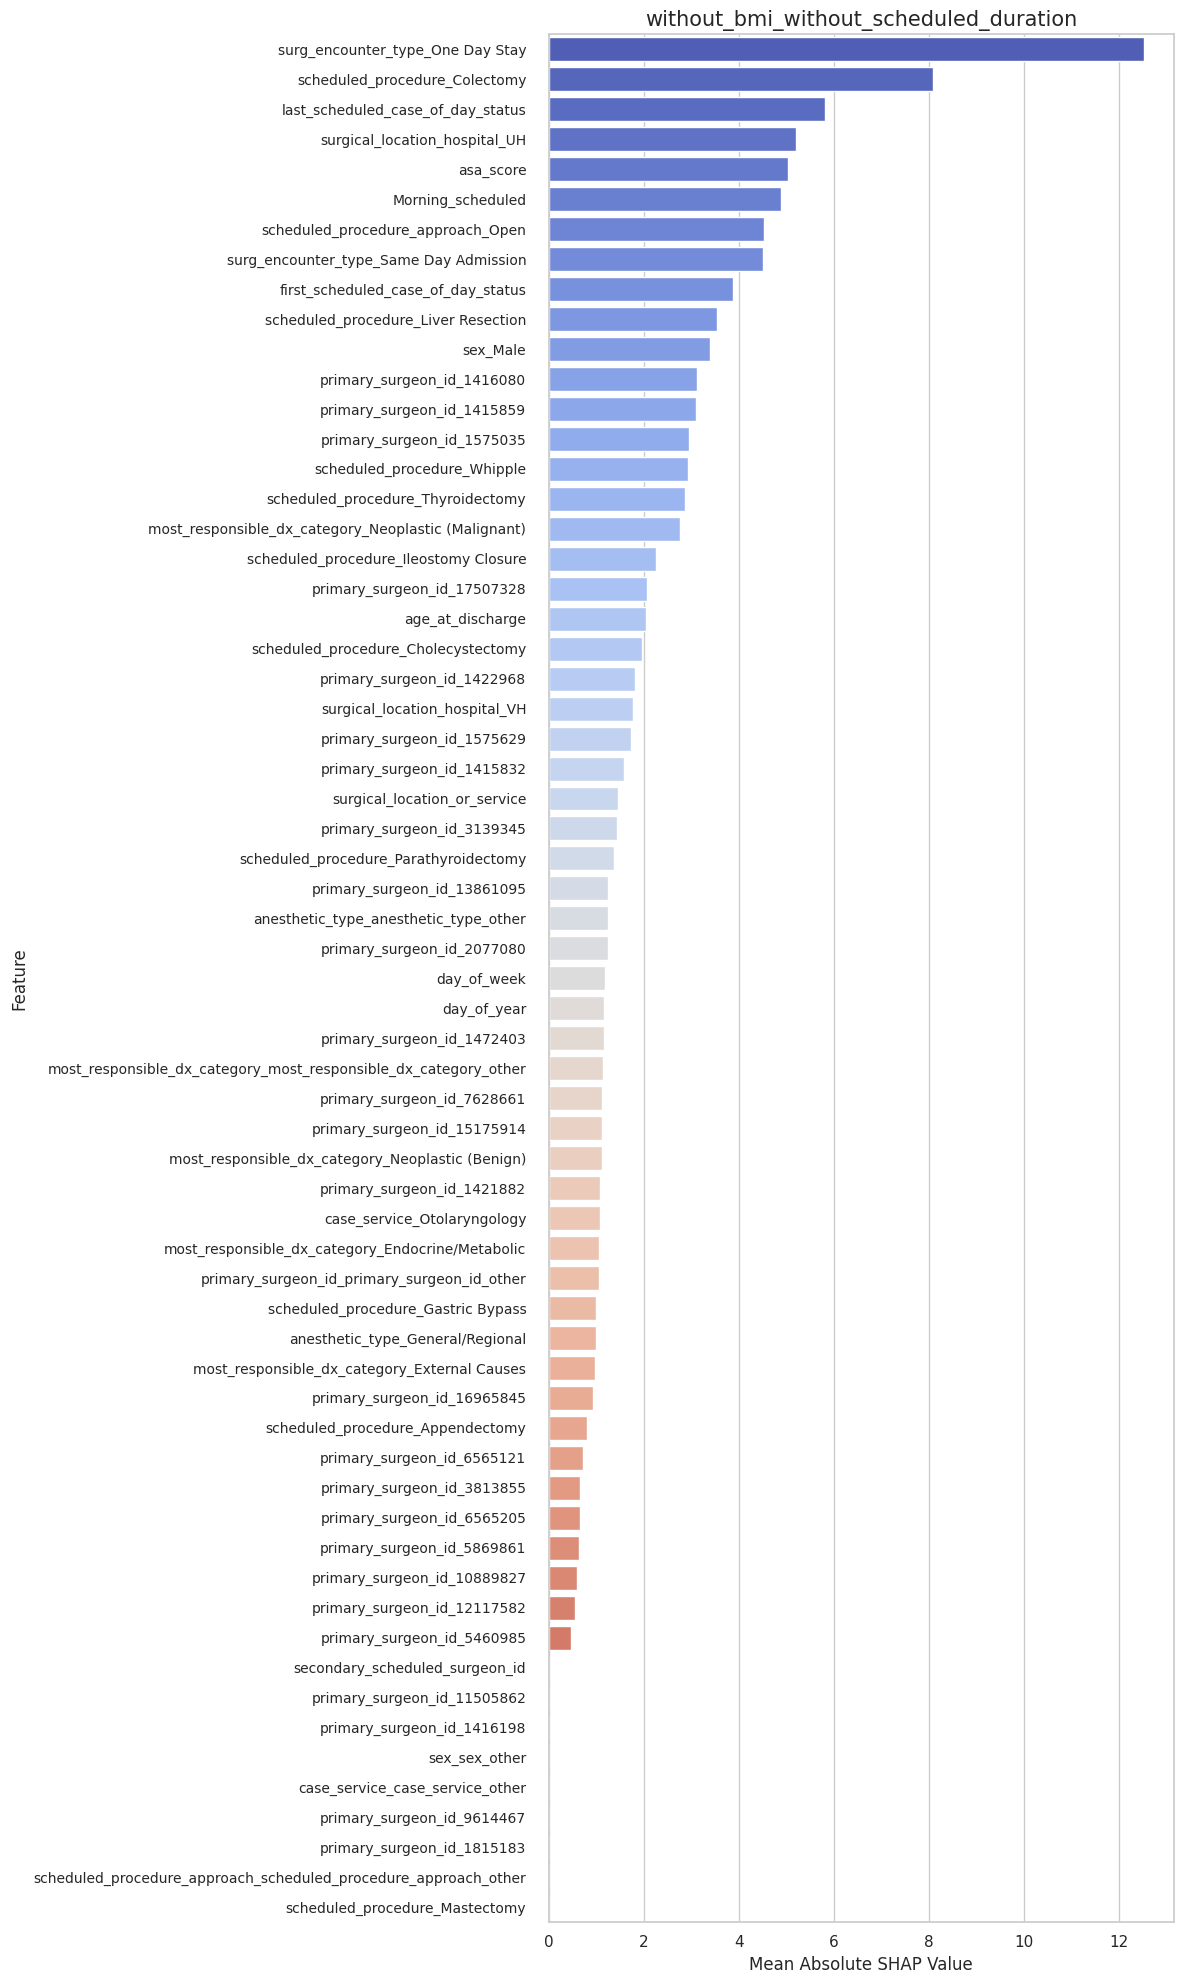

In [4]:
import os
import pandas as pd
import shap
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import numpy as np

# Function to compute SHAP values and plot global feature importance
# Function to compute SHAP values and plot global feature importance
def compute_and_plot_shap_values(model, X_train, folder_path, title):
    explainer = shap.KernelExplainer(model.predict, X_train)
    shap_values = explainer.shap_values(X_train, nsamples=100)

    # If shap_values is a list of arrays, concatenate them
    if isinstance(shap_values, list):
        shap_values = np.concatenate(shap_values, axis=1)
        
    # Flatten the SHAP values if they are 3D
    if shap_values.ndim == 3:
        shap_values = shap_values.reshape(shap_values.shape[0], -1)
    
    # Calculate mean absolute SHAP values for global feature importance
    shap_df = pd.DataFrame(shap_values, columns=X_train.columns)
    shap_summary = shap_df.abs().mean().sort_values(ascending=False)
    
    # Save SHAP values to a CSV file
    shap_df.to_csv(os.path.join(folder_path, 'shap_values.csv'), index=False)

    # Plot global feature importance with improved spacing
    plt.figure(figsize=(12, 20))  # Increased height for better readability
    sns.set(style="whitegrid")
    ax = sns.barplot(x=shap_summary.values, y=shap_summary.index, palette='coolwarm')
    # ax.set_title('Global Feature Importance based on SHAP values', fontsize=15)
    ax.set_title(title, fontsize=15)
    ax.set_xlabel('Mean Absolute SHAP Value', fontsize=12)
    ax.set_ylabel('Feature', fontsize=12)
    
    # Adjust the y-ticks for better spacing
    ax.set_yticks(np.arange(len(shap_summary)))
    ax.set_yticklabels(shap_summary.index, fontsize=10, rotation=0, ha="right", rotation_mode="anchor")

    # Increase the vertical space between ticks
    ax.yaxis.set_tick_params(pad=10)
    
    plt.tight_layout()
    plt.savefig(os.path.join(folder_path, 'global_feature_importance.pdf'))
    plt.show()

    return shap_df

# Define the list of scenarios
scenarios = [
    'with_bmi_with_scheduled_duration',
    'with_bmi_without_scheduled_duration',
    'without_bmi_with_scheduled_duration',
    'without_bmi_without_scheduled_duration'
]

for s in scenarios:
    # Define file paths
    base_dir = './data/'
    folder_name = s
    folder_path = os.path.join(base_dir, folder_name)

    # Load data
    X_train = pd.read_csv(os.path.join(folder_path, 'X_train.csv'), index_col=0)
    X_test = pd.read_csv(os.path.join(folder_path, 'X_test.csv'), index_col=0)
    y_train = pd.read_csv(os.path.join(folder_path, 'Y_train.csv'), index_col=0)
    y_test = pd.read_csv(os.path.join(folder_path, 'Y_test.csv'), index_col=0)

    # Ensure your model is compatible with KernelExplainer
    shap_df = compute_and_plot_shap_values(best_models[s], X_train[:100], folder_path, title=s)
    # print(s)
